# <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4484c2; text-align: center;">Classificator</div>

We will implement a classificator using a SVM model to extract which features or words are key to classify a tweet into real or fake.

In [1]:
# import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import html
from parallel_pandas import ParallelPandas
ParallelPandas.initialize(n_cpu=10,split_factor=2)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

c:\Users\elena\GitHub\MachineLearning-24-25-ProgressTasks\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('words', quiet=True)
nltk.download('punkt_tab', quiet=True)
from nltk.corpus import stopwords

In [3]:
DATA = 'data/'
test = pd.read_csv(DATA + 'Constraint_English_Test.csv', delimiter=';', encoding='utf-8')
train = pd.read_csv(DATA + 'Constraint_English_Train.csv', delimiter=';', encoding='utf-8')
val = pd.read_csv(DATA + 'Constraint_English_Val.csv', delimiter=';', encoding='utf-8')

In [4]:
tweets = pd.concat([train, val, test], ignore_index=True)
tweets.drop(columns=['id'], inplace=True)
tweets['tweet'] = tweets['tweet'].apply(html.unescape)

In [5]:
# remove links that start with 'http' --> https://t.co/... or http://www...
import re
def filter(tweet: str):
    # https://stackoverflow.com/questions/3809401/what-is-a-good-regular-expression-to-match-a-url#3809435
    tweet = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', '', tweet)
    tweet = re.sub(r'\d+', '', tweet)  # remove numbers
    tweet = re.sub(r'^RT @[A-Za-z0-9_]{1,15}:', '', tweet)
    return tweet


tweets['tweet_nolinks'] = tweets['tweet'].apply(filter)

In [6]:
tweets = tweets.drop_duplicates(subset='tweet', keep='first').reset_index(drop=True)

In [7]:
# TF-IDF initialization
tfidf = TfidfVectorizer(use_idf=True, smooth_idf=True,ngram_range=(1,2), stop_words=stopwords.words('english'), max_features=1000)

In [8]:
X = tfidf.fit_transform(tweets['tweet_nolinks'])

label_mapping = {'fake':0, 'real':1}
tweets['label'] = tweets['label'].map(label_mapping)
y = tweets['label']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
svc = SVC(probability=True)

In [11]:
param_grid = {'C': [10, 50, 100, 500],
              'gamma': [0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
model = GridSearchCV(estimator = svc, param_grid = param_grid, cv = 5, verbose = 1, n_jobs = 3, scoring='f1_macro')

In [12]:
# 10 min
model.fit(X_train, y_train)

In [ ]:
import pickle

# with open('model_SVC.pkl', 'rb') as f:
#     best_model = pickle.load(f)

best_model = model.best_estimator_
print(model.best_params_)

# with open('model_SVC.pkl', 'wb') as f:
#     pickle.dump(best_model, f)


In [14]:
y_pred = best_model.predict(X_test)

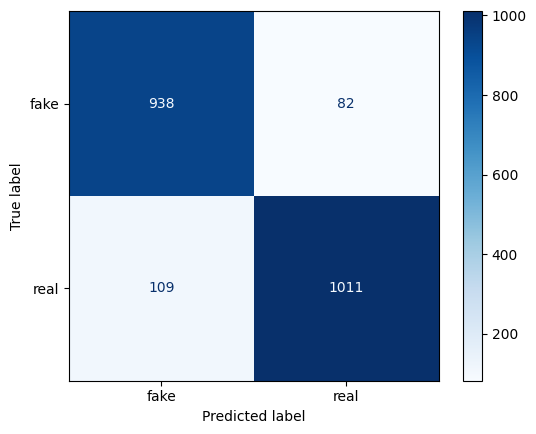

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1020
           1       0.92      0.90      0.91      1120

    accuracy                           0.91      2140
   macro avg       0.91      0.91      0.91      2140
weighted avg       0.91      0.91      0.91      2140



In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['fake', 'real'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(y_test, y_pred))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train)

plt.figure(figsize=(8, 6))
for i, label in enumerate(set(y_train)):
    plt.scatter(
        X_train_pca[y_train == label, 0],
        X_train_pca[y_train == label, 1],
        label=f'Class {label}',
        alpha=0.7
    )
plt.title('PCA train data')
plt.legend()
plt.show()


In [17]:
import shap
shap.initjs()

In [22]:
# data = shap.sample(X_train.toarray(), 200, random_state=42)
# data = shap.kmeans(X_train.toarray(), 200)
# explainer = shap.KernelExplainer(best_model.decision_function, data, feature_names=tfidf.get_feature_names_out())

explainer = shap.SamplingExplainer(best_model.decision_function, X_train.toarray(), feature_names=tfidf.get_feature_names_out(), output_names=['fake', 'real'], seed=42)

In [25]:
X_test[y_test == 0].shape
data_0 = shap.sample(X_test[y_test == 0].toarray(), 5, random_state=42)
data_1 = shap.sample(X_test[y_test == 1].toarray(), 5, random_state=42)
data_test = np.concatenate([data_0, data_1])

In [26]:
shap_values = explainer(data_test)

100%|██████████| 10/10 [36:31<00:00, 219.11s/it]


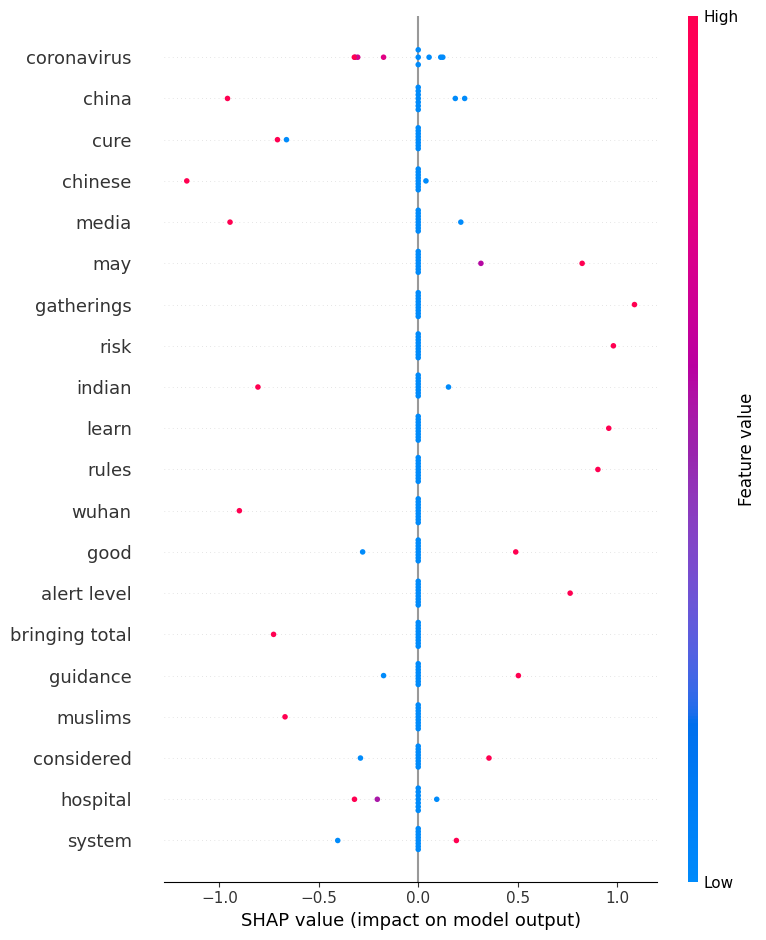

In [ ]:
shap.summary_plot(
    shap_values.values, 
    shap_values.data, 
    feature_names=tfidf.get_feature_names_out()
)
# y: palabras con mayor peso en la clasificación
# colores: valor TFIDF, rojo = alto, azul = bajo
# x: clase real hacia la derecha
# ejemplo: 'china' afecta más a la clasificación de 'fake'

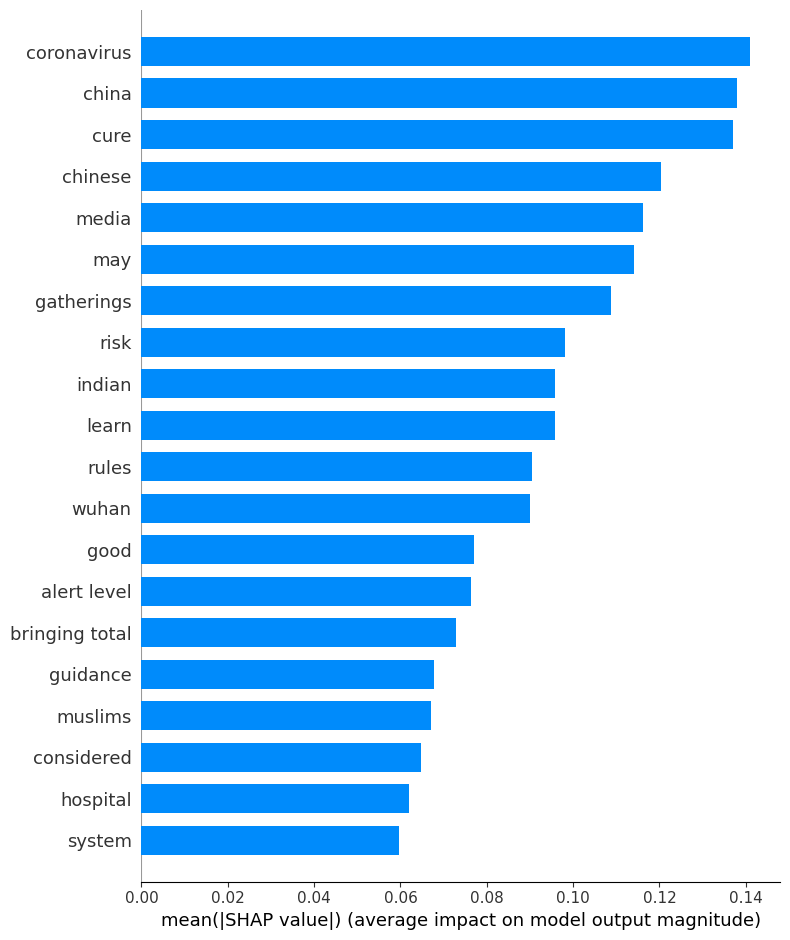

In [46]:
# Crear un bar plot
shap.summary_plot(
    shap_values.values, 
    shap_values.data, 
    feature_names=tfidf.get_feature_names_out(), 
    plot_type="bar"
)

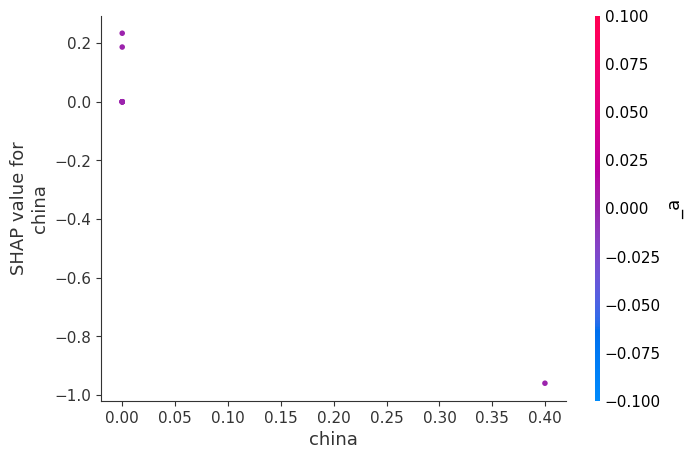

In [29]:
# Visualiza la influencia de una característica específica
shap.dependence_plot(
    "china",  # Cambia por una característica específica
    shap_values.values, 
    shap_values.data, 
    feature_names=tfidf.get_feature_names_out()
)


In [52]:
shap.plots.force(shap_values[0,:], feature_names=tfidf.get_feature_names_out(), matplotlib=False, out_names=['fake', 'real']) 
# base value: prediccion sin influencia de ninguna caracteristica
# rojo: caracteristicas que llevan a la clase positiva
# azul: caracteristicas que llevan a la clase negativa

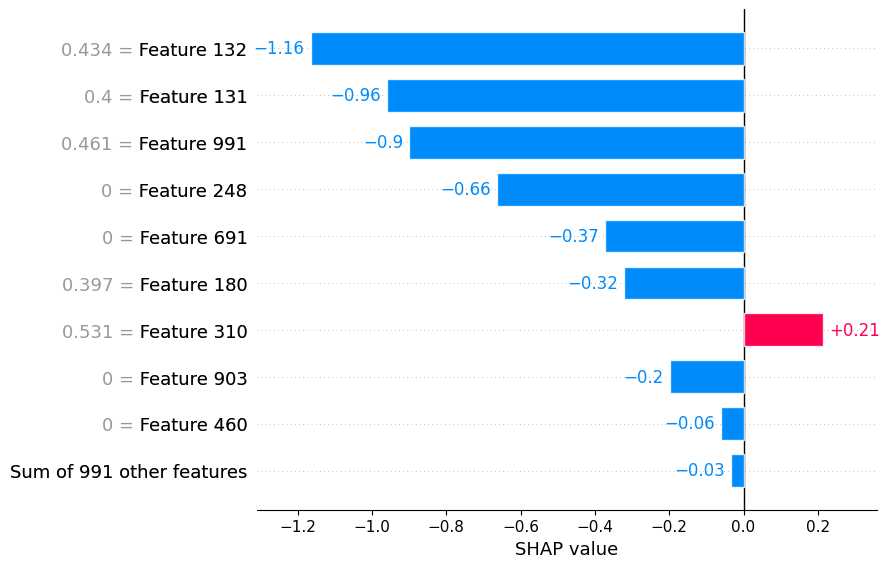

In [ ]:
shap.plots.bar(shap_values[0,:]) #no muestra los nombres de las caracteristicas